In [1]:
#..modified by CHUYAN at Sep10-2021; calculate binned P-E/SST /subsidence and LTS and LWP array in Models: IPSL_CM6A_LR
#..(annual-mean, binned 5X5degree, area-mean data,)

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd


from scipy import stats
from sklearn.linear_model import LinearRegression

In [3]:
#..retrieve variables in pi-control
#..SST
fpath_ts    = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/ts/gr/v20181123/ts/ts_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc' 
#..surface Temperature & Pressure
fpath_ps    = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/ps/gr/v20181123/ps/ps_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
fpath_tas   = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/tas/gr/v20181123/tas/tas_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
#..temperature at levels
fpath_ta    = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/ta/gr/v20181123/ta/ta_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
#..liquid water path
fpath_clivi = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/clivi/gr/v20181123/clivi/clivi_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
fpath_clwvi = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/clwvi/gr/v20181123/clwvi/clwvi_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
#..subsidence
fpath_wap   = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/wap/gr/v20181123/wap/wap_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
#..precipitation flux and water evaporation flux
fpath_p     = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/pr/gr/v20181123/pr/pr_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
fpath_e     = '/glade/collections/cmip/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Amon/evspsbl/gr/v20181123/evspsbl/evspsbl_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'

f_ts        = netCDF4.Dataset(fpath_ts,'r')
f_ta        = netCDF4.Dataset(fpath_ta,'r')
f_tas       = netCDF4.Dataset(fpath_tas,'r')
f_ps        = netCDF4.Dataset(fpath_ps,'r')
f_wap       = netCDF4.Dataset(fpath_wap,'r')
f_clivi     = netCDF4.Dataset(fpath_clivi,'r')
f_clwvi     = netCDF4.Dataset(fpath_clwvi,'r')

f_pr        = netCDF4.Dataset(fpath_p, 'r')
f_ev        = netCDF4.Dataset(fpath_e, 'r')

lons        = f_ts.variables['lon'][:]
lats        = f_ts.variables['lat'][:]
times       = f_ts.variables['time']   #..6000 months -> 500 years


levels      = f_ta.variables['plev']
#print(levels)

In [4]:
lonsipsl        = f_ts.variables['lon'][:]
latsipsl        = f_ts.variables['lat'][:]
timesipsl      = f_ts.variables['time']

levelsipsl      = f_ta.variables['plev']

print(levelsipsl)

<class 'netCDF4._netCDF4.Variable'>
float32 plev(plev)
    name: plev
    standard_name: air_pressure
    long_name: pressure
    units: Pa
    positive: down
unlimited dimensions: 
current shape = (19,)
filling off


In [5]:

#..choose lat 40-85S as the southern Ocean region
lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))


sfc_T       = f_ts.variables['ts']   #..T_skin, also as SST, shape in (6000, 143, 144), units in K
T_700        = f_ta.variables['ta'][:, 3,:,:]
sfc_P       = f_ps.variables['ps']   #..Units in Pa
sub         = f_wap.variables['wap'][:, 5,:,:]    #..500mb downward motions
clivi       = f_clivi.variables['clivi']   #..Units in kg m^-2
clwvi       = f_clwvi.variables['clwvi']
tas         = f_tas.variables['tas']   #..2-m air Temperature, for 'gmt'

P           = f_pr.variables['pr']   #..Units in kg m^-2 s^-1 = mm *s^-1
E           = f_ev.variables['evspsbl']
print(sfc_T.shape)

(6000, 143, 144)


In [6]:
print(latsi1, latsi0)

4 39


In [11]:
Precip =  np.array(P) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip))   #..CESM2..2.388/ IPSL..2.43
Eva    =  np.array(E) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva))         #..CESM2..2.169/ IPSL..2.21
print(Eva.shape)

2.4262097
2.2086403
(6000, 143, 144)


In [8]:
#..Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP  = np.array(clwvi) - np.array(clivi)   #..units in kg m^-2

gmt  = np.array(tas)

SST  = np.array(sfc_T)

MC  = Precip-Eva   #..Moisture Convergence calculated from P - E, Units in mm day^-1

Twp  = np.array(clwvi)
Iwp  = np.array(clivi)

In [9]:
#..Lower Troposphere Stability
k  = 0.286
theta_700  = np.array(T_700)* (100000./70000.)**k

#print(theta_700)

theta_skin = np.array(sfc_T)* (100000./np.array(sfc_P))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m
LTS_e  = np.ma.masked_where(theta_700 >= 500, LTS_m)
#print(LTS_e, LTS_m)

#..Subsidence, units in Pa s^-1 at 500 hPa
Subsidence =  np.array(sub)


In [10]:
#..Convert variables becoming Annual-mean, Southern-Ocean region arrays

Tg  = np.zeros((500,143,144))   #..Surface air Temperature, GMT; need to be attention for the dimensions!!
LWP_yr  = np.zeros((500,35,144))

p_e_yr  = np.zeros((500,35,144))
SST_yr  = np.zeros((500,35,144))
SUB_yr  = np.zeros((500,35,144))
LTS_yr  = np.zeros((500,35,144))
TWP_yr  = np.zeros((500,35,144))
IWP_yr  = np.zeros((500,35,144))
#..annual mean data of LWP, Tg and CCFs

for i in range(0, 500):
    Tg[i,:,:]     = np.nanmean(gmt[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr[i,:,:]  = np.nanmean(LWP[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr[i,:,:] = np.nanmean(MC[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr[i,:,:]    = np.nanmean(SST[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr[i,:,:]    = np.nanmean(LTS_e[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr[i,:,:]    = np.nanmean(Subsidence[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr[i,:,:]  = np.nanmean(Twp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr[i,:,:]  = np.nanmean(Iwp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)

print(LWP_yr.shape)
#print(lat_array.shape,lon_array)

(500, 35, 144)


In [12]:
#..set bin boxes's lat/lon range

x_range  = np.arange(0., 364, 5.)   #..number:73
y_range  = np.arange(-85., -35, 5.)   #..number 40 S - 85 S(10)
xbins, ybins = len(x_range), len(y_range)

print(y_range.shape, xbins, ybins)


(10,) 73 10


In [13]:
def binned_cySouthOcean5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Southern Ocean region from 85S 40S
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-85., -35, 5.)   #.. (10)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [14]:
#..Calculate 5*5 binned array for variables(LWP, ccfs) in Sounthern Ocean region

lat_array  = lats[latsi1:latsi0]
lon_array  = lons

SST_yr_bin  = binned_cySouthOcean5(SST_yr, lat_array, lon_array)

p_e_yr_bin  = binned_cySouthOcean5(p_e_yr, lat_array, lon_array)
LWP_yr_bin  = binned_cySouthOcean5(LWP_yr, lat_array, lon_array)   #..shape in (500,10,73)

LTS_yr_bin  = binned_cySouthOcean5(LTS_yr, lat_array, lon_array)
SUB_yr_bin  = binned_cySouthOcean5(SUB_yr, lat_array, lon_array)
TWP_yr_bin  = binned_cySouthOcean5(TWP_yr, lat_array, lon_array)
IWP_yr_bin  = binned_cySouthOcean5(IWP_yr, lat_array, lon_array)
print(SUB_yr_bin.shape)   #..(500, 10, 73)



(500, 10, 73)


In [19]:
#..Ravel binned array / Standardized data ARRAY:

LWP_predi  = LWP_yr_bin.flatten() 
#LWP_predi =  (LWP_predi - np.mean(LWP_predi) )/np.std(LWP_predi)

SST_predi  = SST_yr_bin.flatten()  
#SST_predi =  (SST_predi - np.mean(SST_predi)) /np.std(SST_predi)

p_e_predi =  p_e_yr_bin.flatten()
#p_e_predi =  (p_e_predi - np.mean(p_e_predi)) /np.std(p_e_predi)

LTS_predi  = LTS_yr_bin.flatten()
#LTS_predi =  (LTS_predi - np.nanmean(LTS_predi)) /np.nanstd(LTS_predi)

SUB_predi  = SUB_yr_bin.flatten()
#SUB_predi  = (SUB_predi - np.mean(SUB_predi)) /np.std(SUB_predi)

print(np.max(LTS_predi), np.max(SUB_predi))

#..Subtract 'nan' in data, 365000 -> 342864points
ind2 =  np.isnan(LTS_predi)==False   
print(ind2.shape)

print(LTS_predi[ind2].shape)

nan 0.1412454596720636
(365000,)
(342864,)


In [20]:
#..Remove abnormal and missing_values:

X  = np.array([SST_predi[ind2], p_e_predi[ind2] ,LTS_predi[ind2], SUB_predi[ind2]])

print(X)
print(X.shape)

X2  = np.array([SST_predi[ind2], p_e_predi[ind2]])

[[ 2.24734957e+02  2.23175863e+02  2.22226473e+02 ...  2.80362869e+02
   2.81287196e+02  2.81390549e+02]
 [ 1.11807164e-01  9.06492593e-02  7.69643411e-02 ...  2.63829915e+00
   1.96712561e+00  1.95900655e+00]
 [ 1.64946254e+01  1.15725679e+01  6.93860185e+00 ...  1.18718753e+01
   1.09824440e+01  1.10181053e+01]
 [ 3.03536227e-02  3.03853280e-02  1.92308308e-02 ... -1.63014571e-02
  -1.43404820e-02 -9.90433820e-03]]
(4, 342864)


In [21]:
#..Multiple linear regreesion of Liquid water path(lwp) to (CCF)Cloud Controlling Factors:

result1 = LinearRegression().fit(X.T, LWP_predi[ind2])

print(result1.coef_)
print(result1.intercept_)

#result1.score(X.T, LWP_predi[ind2])


#result1.predict()

[ 0.00260983  0.00953104 -0.00220453  0.41585783]
-0.6047988210526626


In [22]:
coef1  = result1.coef_
np.save('sensitivity_4ccfs_ipsl.npy', coef1)

intercept1  = result1.intercept_
np.save('intercept1_ipsl.npy', intercept1)


In [23]:
aeffi  = np.load('sensitivity_4ccfs.npy')
beffi  = np.load('sensitivity_4ccfs_ipsl.npy')
print(aeffi, ' ',beffi)

[ 0.0022244   0.01740707 -0.00166793  0.02882105]   [ 0.00260983  0.00953104 -0.00220453  0.41585783]


In [20]:
#..Multiple linear regreesion of Liquid water path to CCF Cloud Controlling Factors:

result2 = LinearRegression().fit(X2.T, LWP_predi[ind2])
print(result2.coef_)
print(result2.intercept_)

result2.score(X2.T, LWP_predi[ind2])

[0.00267261 0.00914946]
-0.6522303179984377


0.7328482516131338

In [21]:
coef2  = result2.coef_
np.save('sensitivity_2ccfs_ipsl.npy', coef2)

(1, 342864)
(365000,)


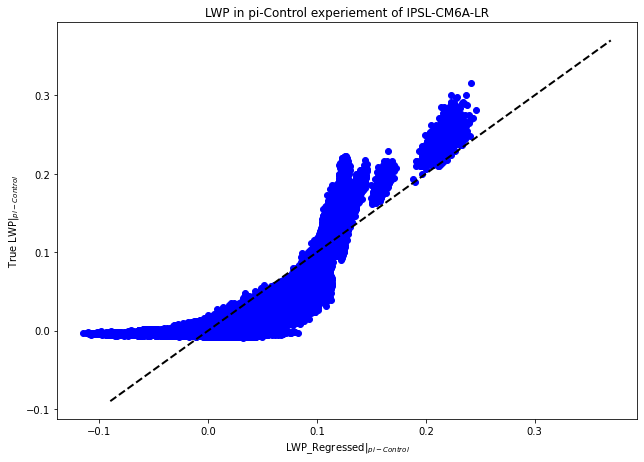

In [30]:
#..draw the plot for 'pi-Cont' experiment's LWP and the predicted LWP from linear Regression Model trained in 'pi-control'

fig2  = plt.figure(figsize = (10.4, 7.3))
ax2  = plt.axes()


apt  = np.dot(beffi.reshape(1, -1), X)
cpt  = apt + intercept1
plt.scatter(cpt.flatten(), LWP_predi[ind2], c  = 'b')

print(cpt.shape)
print(LWP_predi.shape)

#..Add reference LINE
x  = np.linspace(-0.09, 0.37, 50)
y  = x
plt.plot(x, y, color='k', linewidth =2, linestyle =  'dashed')

#plt.ylim((0.105, 0.121))


plt.xlabel('LWP_Regressed$|_{pi-Control}$')
plt.ylabel('True LWP$|_{pi-Control}$')
plt.title("LWP in pi-Control experiement of IPSL-CM6A-LR")


plt.savefig("LWP_distribution_IPSL.png")



In [23]:
#..Test..
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])

x1 = np.random.normal(0.,1.,size=100,)

a =  0.8
b =  np.sqrt(1. - a**2)
x2 =  []

In [24]:
x = [0.1, 0.55, 0.1, 0.6, 0.1,0.3, 0.6]
y = [2.1, 2.6, 2.1, 2.1,  2.6,2.3 , 2.3]
binx = [0.0, 0.5, 1.0]
biny = [2.0, 2.5, 3.0]
ret = stats.binned_statistic_2d(x, y, None, 'count', bins=[binx, biny], expand_binnumbers = True)

print(ret.statistic)
ret.binnumber

[[3. 1.]
 [2. 1.]]


array([[1, 2, 1, 2, 1, 1, 2],
       [1, 2, 1, 1, 2, 1, 1]])